In [1]:
cd C:\Users\zhang\Documents\Experiment\RBF-StyleGAN

C:\Users\zhang\Documents\Experiment\RBF-StyleGAN


RBF to map image to latent code

In [2]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
from PIL import Image 
import torch
from models.model_settings import MODEL_POOL
from models.stylegan_generator import StyleGANGenerator
import matplotlib.pyplot as plt

In [3]:
model_name = "stylegan_ffhq"
latent_space_type = "W" #@param ['Z', 'W']
generator = StyleGANGenerator(model_name)

[2022-11-03 16:25:17,533][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2022-11-03 16:25:17,633][INFO] Successfully loaded!
[2022-11-03 16:25:17,634][INFO]   `lod` of the loaded model is 0.0.


In [4]:
import pickle
with open('rbfm16000.pkl', 'rb') as f:
    rbf_loaded = pickle.load(f)

C:\Users\zhang\anaconda3\envs\cuda_0\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(1, 30000)


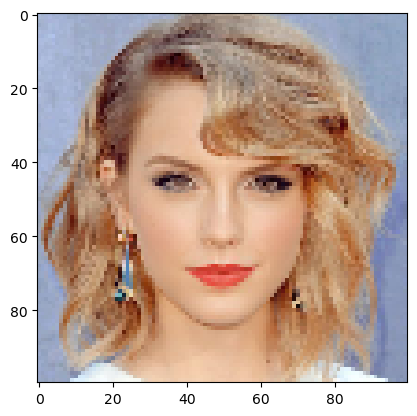

In [5]:
im1 = Image.open(r"C:\Users\zhang\Documents\Experiment\RBF\source_image\32.png") 
imm = im1.resize((100, 100))
imm.save('test000.png')
img2 = np.array(im1)
ims = cv2.resize(img2, (100,100))
image5 = np.array([ims])
image3 = np.array([image5.ravel()])
print(image3.shape)
import matplotlib.pyplot as plt
plt.imshow(ims)

In [6]:
newCode = rbf_loaded(image3)

(-0.5, 1023.5, 1023.5, -0.5)

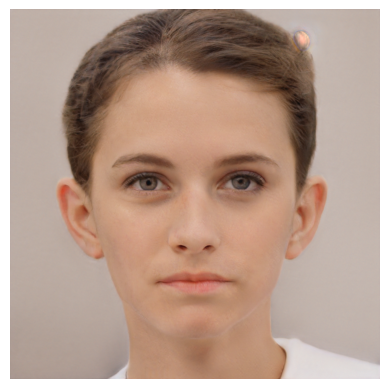

In [7]:
synthesis_kwargs = {'latent_space_type': 'W'}
images = generator.easy_synthesize(newCode, **synthesis_kwargs)['image']
plt.imshow(images[0])
plt.axis("off")

Optimization

In [8]:
from models.stylegan_layers import  G_mapping,G_synthesis
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torchvision import models
from torchvision.utils import save_image
from math import log10

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all = nn.Sequential(OrderedDict([('g_mapping', G_mapping()),
    #('truncation', Truncation(avg_latent)),
    ('g_synthesis', G_synthesis(resolution=1024))    
    ]))

#Load the pre-trained model
g_all.load_state_dict(torch.load('C:/Users/zhang/Documents/Experiment/StyleGAN_LatentEditor/weight_files/pytorch/karras2019stylegan-ffhq-1024x1024.for_g_all.pt', map_location=device))
g_all.eval()
g_all.to(device)
g_mapping, g_synthesis = g_all[0],g_all[1]

In [10]:
class VGG16_perceptual(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16_perceptual, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 4):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 14):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(14, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_1 = h
        h = self.slice2(h)
        h_relu1_2 = h
        h = self.slice3(h)
        h_relu3_2 = h
        h = self.slice4(h)
        h_relu4_2 = h
        return h_relu1_1, h_relu1_2, h_relu3_2, h_relu4_2

In [11]:
def loss_function(syn_img, img, img_p, MSE_loss, upsample, perceptual):

  #UpSample synthesized image to match the input size of VGG-16 input. 
  #Extract mid level features for real and synthesized image and find the MSE loss between them for perceptual loss. 
  #Find MSE loss between the real and synthesized images of actual size
    syn_img_p = syn_img.clone()
#     syn_img_p = upsample(syn_img)
    syn0, syn1, syn2, syn3 = perceptual(syn_img_p)
    r0, r1, r2, r3 = perceptual(img_p)
    mse = MSE_loss(syn_img,img)

    per_loss = 0
    per_loss += MSE_loss(syn0,r0)
    per_loss += MSE_loss(syn1,r1)
    per_loss += MSE_loss(syn2,r2)
    per_loss += MSE_loss(syn3,r3)

    return mse, per_loss

In [12]:
def PSNR(mse, flag = 0):
  #flag = 0 if a single image is used and 1 if loss for a batch of images is to be calculated
  if flag == 0:
    psnr = 10 * log10(1 / mse.item())
  return psnr

In [13]:
psnr_total = []

In [14]:
def embed_to_W(image, latent_code, image_id):
    '''
    encode images to W space
    '''
#     upsample = torch.nn.Upsample(scale_factor= 256 / 1024, mode='bilinear')
    upsample = torch.nn.Upsample(scale_factor= 100 / 1024, mode='bilinear')
    img_p = image.clone()
#     img_p = upsample(img_p)
    perceptual = VGG16_perceptual().to(device)

    MSE_loss = nn.MSELoss(reduction="mean")
    latent_w =  torch.tensor( latent_code, requires_grad=True, device=device, dtype=torch.float32)
    torch.zeros((1, 512), requires_grad=True, device=device)
    torch.tensor( latent_code, requires_grad=True, device=device)
    

    optimizer = optim.Adam({latent_w}, lr=0.01, betas=(0.9, 0.999), eps=1e-8)

    loss_ = []
    loss_psnr = []
    for e in range(3000):
        optimizer.zero_grad()
        latent_w1 = latent_w.unsqueeze(1).expand(-1, 18, -1)
        syn_img = g_synthesis(latent_w1)
        syn_img = (syn_img + 1.0) / 2.0
        syn_img = upsample(syn_img)
        mse, per_loss = loss_function(syn_img, image, img_p, MSE_loss, upsample, perceptual)
        psnr = PSNR(mse, flag=0)
        loss = per_loss + mse
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        loss_p = per_loss.detach().cpu().numpy()
        loss_m = mse.detach().cpu().numpy()
        loss_psnr.append(psnr)
        loss_.append(loss_np)
        if (e + 1) % 500 == 0:
            print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}, psnr --{}".format(e + 1, loss_np, loss_m,
                                                                                            loss_p, psnr))
            save_image(syn_img.clamp(0, 1),
                       "wspace-{}-{}.png".format(image_id, e + 1))

    plt.plot(loss_, label='Loss = MSELoss + Perceptual')
    plt.plot(loss_psnr, label='PSNR')
    plt.legend()
    print(loss_psnr[-1])
    return latent_w

torch.Size([1, 3, 100, 100])


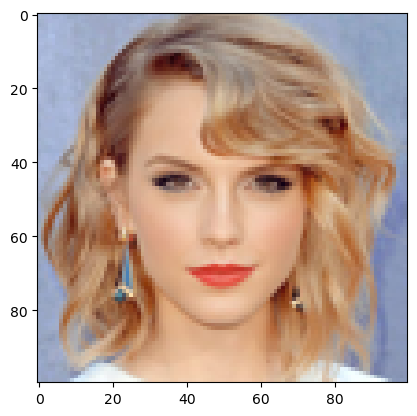

In [15]:
img_path = "test000.png"
# "C:/Users/zhang/Documents/Experiment/RBF/source_image/test000.png"


with open(img_path,"rb") as f: 
    image1=Image.open(f)
    image1=image1.convert("RGB")
    plt.imshow(image1)
#   image1 = image1.resize((1024,1024),Image.NEAREST)
#   image1.save('test0001.png')
transform = transforms.Compose([transforms.ToTensor()])
image1 = transform( image1)
image1 = image1.unsqueeze(0)
image1 = image1.to(device)
print(image1.shape)

C:\Users\zhang\anaconda3\envs\cuda_0\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zhang\anaconda3\envs\cuda_0\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


iter500: loss -- 5.484517574310303,  mse_loss --0.024182554334402084,  percep_loss --5.4603352546691895, psnr --16.164978277620197
iter1000: loss -- 5.3422441482543945,  mse_loss --0.022948026657104492,  percep_loss --5.319295883178711, psnr --16.39254654300026
iter1500: loss -- 4.7488861083984375,  mse_loss --0.018651001155376434,  percep_loss --4.7302350997924805, psnr --17.292978510088737
iter2000: loss -- 4.433898448944092,  mse_loss --0.01609778217971325,  percep_loss --4.4178009033203125, psnr --17.93233953375563
iter2500: loss -- 4.121570587158203,  mse_loss --0.014737717807292938,  percep_loss --4.106832981109619, psnr --18.315697634536686
iter3000: loss -- 4.093355178833008,  mse_loss --0.016447432339191437,  percep_loss --4.076907634735107, psnr --17.8390189151088
17.8390189151088


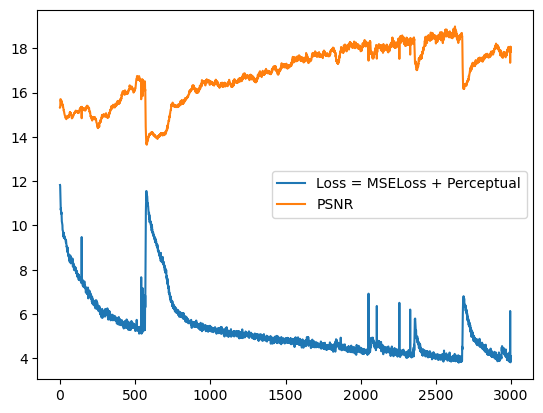

In [16]:
latent_w = embed_to_W(image1,newCode,'1')
wcode = latent_w.cpu().detach().numpy()


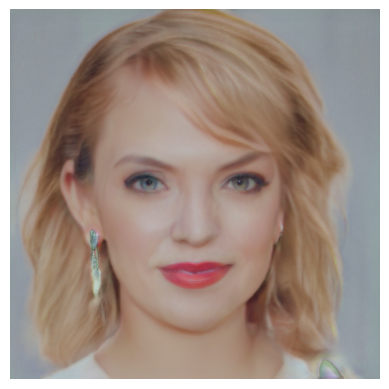

In [17]:
synthesis_kwargs = {'latent_space_type': 'W'}
images = generator.easy_synthesize(wcode, **synthesis_kwargs)['image']
plt.imshow(images[0])
plt.axis("off")
img = Image.fromarray(images[0], 'RGB')
img.save('reconstructed_image.png')

np.save("image_latent_code.npy",wcode)

Editing

In [18]:
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  if generator.gan_type == 'stylegan' :
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

In [19]:

num_samples = 1 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 0 #@param {type:"slider", min:0, max:1000, step:1}

# latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if generator.gan_type == 'stylegan':
  synthesis_kwargs = {'latent_space_type': latent_space_type}
else:
  synthesis_kwargs = {}

(-0.5, 1023.5, 1023.5, -0.5)

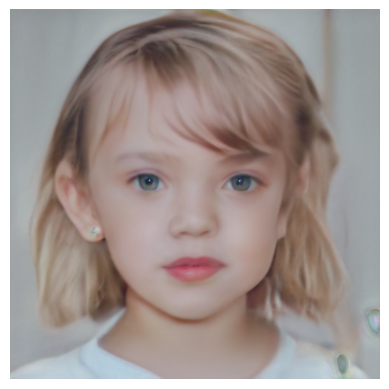

In [20]:
age = -3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = 0 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
if latent_space_type == 'W':
  new_codes = wcode.copy()
  # new_codes = latent_code_zz.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
plt.imshow(new_images[0])
plt.axis("off")